In [1]:
import folium
import geopandas as gpd
import cv2
import numpy as np
import pystac_client
import rasterio
import shapely

from datetime import datetime
from pystac import Catalog
from rasterio.plot import show
from shapely.geometry import shape

%load_ext autoreload
%autoreload 2

In [2]:
client = pystac_client.Client.open("https://maxar-opendata.s3.amazonaws.com/events/catalog.json")

/usr/local/Caskroom/miniconda/base/envs/gic-rs/lib/python3.11/site-packages/pystac_client/client.py:190: NoConformsTo: Server does not advertise any conformance classes.
  warnings.warn(NoConformsTo())


In [3]:
client.id

'maxar-opendata'

In [4]:
client.description

'Maxar ARD Open Data Catalog'

In [5]:
collections = list(client.get_collections())
n_collections = len(collections)

/usr/local/Caskroom/miniconda/base/envs/gic-rs/lib/python3.11/site-packages/pystac_client/client.py:440: FallbackToPystac: Falling back to pystac. This might be slow.
  self._warn_about_fallback("COLLECTIONS", "FEATURES")


In [6]:
for c in collections:
    if "24" in c.id or "25" in c.id:
        print(c.id)

Belize-Wildfires-June24
Brazil-Flooding-May24
Floods-Spain-Oct24
HurricaneHelene-Oct24
HurricaneMilton-Oct24
Japan-Earthquake-Jan-2024
Kenya-Flooding-May24
Nepal-Floods-Sept-2024
Nigeria-Floods-Sept-2024
PNG-Landslide-June24
SmokeHouseCreek-Wildfires-Texas-Mar24
WildFires-LosAngeles-Jan-2025


In [7]:
la2025_collection = [c for c in collections if "25" in c.id][0]
la2025_collection

<CollectionClient id=WildFires-LosAngeles-Jan-2025>

In [8]:
date = "2024-12-14/2024-12-31"

In [9]:
la2025_collections = la2025_collection.get_all_collections()
la2025_collections

<generator object Catalog.get_all_collections at 0x15ab9fed0>

In [10]:
collection_t0 = list(la2025_collections)[0]
collection_t0

<CollectionClient id=103001010A705C00>

In [11]:
items = collection_t0.get_all_items()
items

In [12]:
item_list = list(items)

/usr/local/Caskroom/miniconda/base/envs/gic-rs/lib/python3.11/site-packages/pystac_client/collection_client.py:153: FallbackToPystac: Falling back to pystac. This might be slow.
  root._warn_about_fallback("ITEM_SEARCH")


In [13]:
geometries = []
properties_list = []

for item in item_list:
    geometry = shape(item.properties['proj:geometry'])
    geometries.append(geometry)
    properties_list.append(item.properties)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(properties_list, geometry=geometries, crs="epsg:32611")
gdf.crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
m = gdf.to_crs(epsg=4326).explore(column='tile:clouds_area')
m

In [15]:
catalog_ids = gdf.catalog_id.to_list()
len(catalog_ids)

12

In [16]:
len(set(catalog_ids))

1

In [17]:
BASE_URL = "https://maxar-opendata.s3.amazonaws.com/events/WildFires-LosAngeles-Jan-2025/ard/"

In [18]:
item0 = item_list[2]

In [19]:
datetime.strptime(item0.properties['datetime'], '%Y-%m-%d %H:%M:%SZ')

datetime.datetime(2024, 12, 14, 18, 53, 50)

In [20]:
item0

<Item id=11/031311102010/103001010A705C00>

In [21]:
# Choose an asset. Here we use the 'visual' asset if available, otherwise the first asset.
asset_tiff_href = item0.assets.get("visual", list(item0.assets.values())[0]).href
asset_tiff_href = asset_tiff_href.lstrip(".")
quad_key = item0.properties['quadkey']
utm_zone = item0.id.split("/")[0]
item_date = datetime.strptime(item0.properties['datetime'], '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d')#datetime.strptime(item0.properties['datetime'], '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%d')
asset_href = BASE_URL + utm_zone + "/" + quad_key + "/" + item_date + asset_tiff_href

In [22]:
asset_href

'https://maxar-opendata.s3.amazonaws.com/events/WildFires-LosAngeles-Jan-2025/ard/11/031311102010/2024-12-14/103001010A705C00-visual.tif'

In [23]:
item0

<Item id=11/031311102010/103001010A705C00>

In [24]:
import matplotlib.pyplot as plt

with rasterio.open(f"/vsicurl/{asset_href}") as src:
    img = src.read([1, 2, 3])

In [25]:
# Transpose the image data to be in the correct shape (height, width, bands)
img_rgb = np.moveaxis(img, 0, -1)


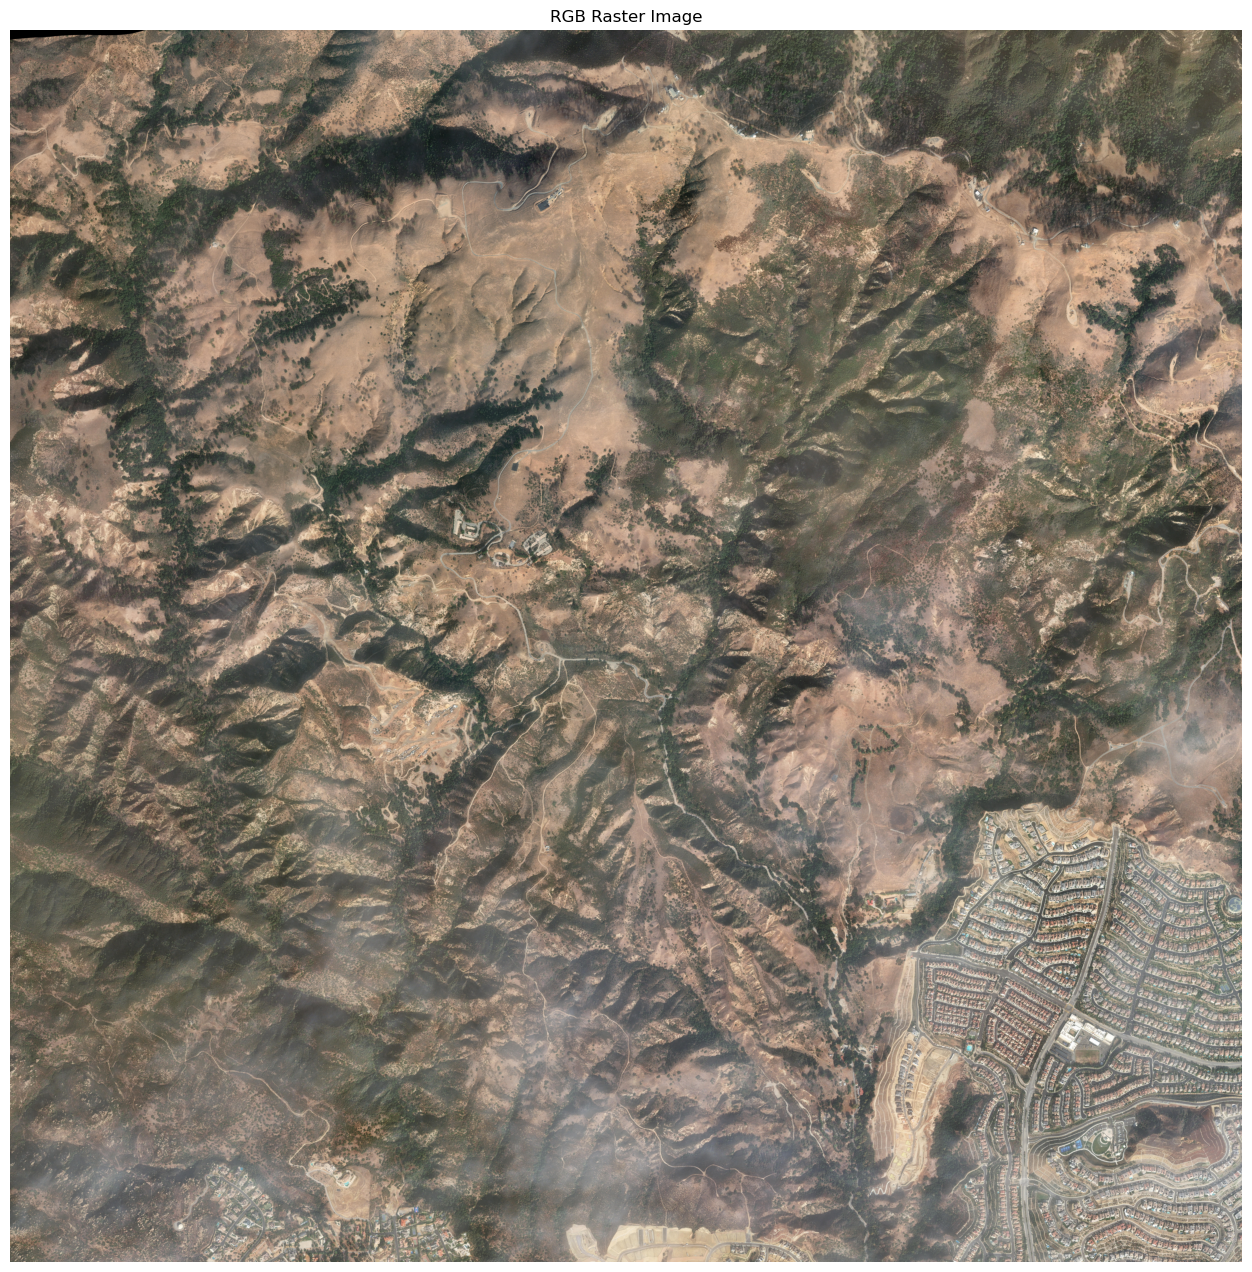

In [26]:
# Plot the RGB image using matplotlib
plt.figure(figsize=(20, 16))
plt.imshow(img_rgb)
plt.title('RGB Raster Image')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('off')  # Optionally turn off axis numbers and ticks
plt.show()

In [27]:
import numpy as np
import torch

print("NumPy version:", np.__version__)
print("Torch version:", torch.__version__)

# Test converting a numpy array to a torch tensor
arr = np.array([1, 2, 3], dtype=np.float32)
tensor = torch.from_numpy(arr)
print("Tensor:", tensor)

NumPy version: 1.24.3
Torch version: 2.2.2
Tensor: tensor([1., 2., 3.])


In [57]:
import requests
import tempfile
import os
import rasterio
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt

# First download the image
def download_image(url, output_path):
    response = requests.get(url)
    with open(output_path, 'wb') as f:
        f.write(response.content)
    print(f"Image downloaded to {output_path}")

# Create a temporary file
temp_dir = tempfile.gettempdir()
temp_file = os.path.join(temp_dir, "satellite_image.tif")

# Download the image
image_url = asset_href  # Your URL here
download_image(image_url, temp_file)

# Now read it locally
with rasterio.open(temp_file) as src:
    image_patch = src.read([1, 2, 3], window=rasterio.windows.Window(0, 0, 512, 512))
    print("Image shape:", image_patch.shape)


Image downloaded to /var/folders/zz/3lhn60g1163cfzw5vrc_yrp00000gn/T/satellite_image.tif
Image shape: (3, 512, 512)


In [64]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

# Simple model for building detection
class SimpleBuildingDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a pre-trained ResNet18 (smaller than ResNet50)
        self.model = models.resnet18(pretrained=True)
        
        # Modify for satellite imagery (3 channels)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Simplify the final layers
        self.model.fc = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

# Process a single image patch
def detect_buildings(image_patch):
    # Ensure image is float and normalized
    image = image_patch.astype(np.float32) / 255.0
    
    # Convert to tensor
    image_tensor = torch.from_numpy(image).unsqueeze(0)  # Add batch dimension
    
    # Create and use model
    model = SimpleBuildingDetector()
    model.eval()
    
    with torch.no_grad():
        prediction = model(image_tensor)
    
    return prediction.squeeze().numpy()

# Get building prediction
building_mask = detect_buildings(image_patch)

RuntimeError: could not create a primitive

In [65]:
building_mask

array(0.38938195, dtype=float32)

TypeError: Invalid shape () for image data

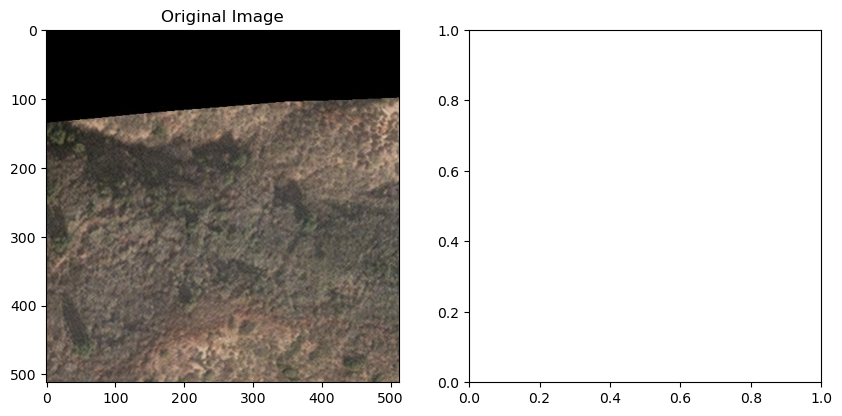

In [39]:
# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image_patch, (1, 2, 0)))  # Original image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(building_mask, cmap='gray')  # Prediction
plt.title('Building Prediction')
plt.show()

In [30]:
print("Original image shape:", img.shape)

Original image shape: (3, 17408, 17408)


In [74]:
np.__version__

'1.25.0'

In [75]:
import torch
import torchvision
import torchvision.models as models
import numpy as np

# Create a small random image to test
test_image = np.ascontiguousarray(np.random.rand(3, 512, 512).astype(np.float32))
print("Test image shape:", test_image.shape)
print("Test image min/max:", test_image.min(), test_image.max())

# Convert to tensor using torch.tensor() to force a copy
image_tensor = torch.tensor(test_image).unsqueeze(0)
print("Tensor shape:", image_tensor.shape)
print("Tensor min/max:", image_tensor.min(), image_tensor.max())

# Try loading just the model
try:
    model = models.resnet18(pretrained=True)
    print("Basic ResNet18 loaded successfully")
    
    # Try a forward pass
    with torch.no_grad():
        output = model(image_tensor)
    print("Forward pass successful")
    
except Exception as e:
    print("Error:", str(e))
    print("Torch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)

Test image shape: (3, 512, 512)
Test image min/max: 2.6851194e-06 0.99999887
Tensor shape: torch.Size([1, 3, 512, 512])
Tensor min/max: tensor(2.6851e-06) tensor(1.0000)
Basic ResNet18 loaded successfully
Error: could not create a primitive
Torch version: 2.2.2
Torchvision version: 0.17.2


/usr/local/Caskroom/miniconda/base/envs/gic-rs/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/gic-rs/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

PyTorch version: 2.2.2
Torchvision version: 0.17.2
CUDA available: False
Device: cpu


In [76]:
torch.__version__

'2.2.2'

In [ ]:
pip install numpy==1.24.3